In [87]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# Exploring the data

In [88]:
# importing and inspecting the data
df = pd.read_csv('lang_data.csv')

df.head()

,text,language
0,Ship shape and Bristol fashion,English
1,Know the ropes,English
2,Graveyard shift,English
3,Milk of human kindness,English
4,Touch with a barge-pole - Wouldn't,English


In [89]:
df.describe()

,text,language
count,2761,2839
unique,2752,3
top,A dog is a man's best friend,English
freq,2,2077


In [90]:
# inspecting the data
initial_rows = df.shape[0]
print(f"The dataframe has {initial_rows} rows.")

The dataframe has 2839 rows.


In [91]:
# checking whether we have any inconsitencies in the labels - fortunately, we only have 3 unique labels assigned to eact string of text
print(df['language'].unique())

['English' 'Afrikaans' 'Nederlands']


In [92]:
# checking the distribution of the languages
df['language'].value_counts(normalize=True) * 100

English       73.159563
Afrikaans     23.635083
Nederlands     3.205354
Name: language, dtype: float64

From the above we see that we have an imbalanced dataset, with the vast majority of the observations belonging to either the English or Afrikaans languages. Roughly 3% of the text is Dutch.

In [93]:
# checking the nature of the text column in the dataframe
# print the first 20 text entries
for i in range(0,11):
    print(df['text'][i])

Ship shape and Bristol fashion
Know the ropes
Graveyard shift
Milk of human kindness
Touch with a barge-pole - Wouldn't
Sy kan altyd my battery natpiepie.
When the shit hits the fan
nan
Egg on
Drag race
As queer as a nine bob note


From the above we can see that this column will need some engineering before being passed to the model. For example. remove hypens and convert all the words to lower case. This will be done in the Feature engineering section below.

# Cleaning the data

In [94]:
# checking the distribution of the languages after having dropped some rows
# this is to check which languages have more missing values 
df['language'].value_counts(normalize=True) * 100

English       73.159563
Afrikaans     23.635083
Nederlands     3.205354
Name: language, dtype: float64

In [95]:
# checking for any missing data
df.isnull().values.any() # this line of code returns True if any data is missing, else it returns False
df_reduced = df.copy()
df_reduced = df_reduced.dropna(how = "any")
reduced_rows = df_reduced.shape[0]
print(f"There are {initial_rows} rows in total, of which {initial_rows - reduced_rows} contain missing values.")

percentage_missing_data = (initial_rows - reduced_rows)/initial_rows*100
percentage_missing_data = "{:.2f}".format(percentage_missing_data)
print(f"Percentage missing data = {percentage_missing_data}")

There are 2839 rows in total, of which 78 contain missing values.
Percentage missing data = 2.75


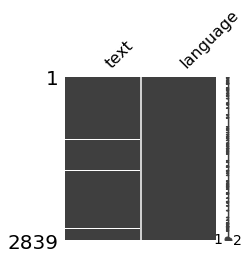

In [96]:
# Plot graphic of missing values
import missingno
missingno.matrix(df, figsize = (3,3))
plt.show()

The missing data represents a small proportion of the total dataframe. We will therefore omit the rows where there are missing data.

In [97]:
# checking the distribution of the languages after having dropped some rows
# this is to check which languages have more missing values 
df_reduced['language'].value_counts(normalize=True) * 100

English       74.429555
Afrikaans     23.143788
Nederlands     2.426657
Name: language, dtype: float64

Comparing the above figures to those we observed before omitting the missing value rows, we see that most of the missing values were assigned to either the Afrikaans or Dutch languages. This exacerbates the imbalanced dataset problem we are faced with. This will be dealt with in the Modeling section below. 

# Feature engineering

In [98]:
import re

def process_sentence(sentence):
    '''Removes all special characters from the sentence. It will also strip out
    extra whitespace and makes the string lowercase.
    '''
    return re.sub(r'[\\\\/:*«`\'?¿";!<>,.|-]', '', sentence.lower().strip())


In [99]:
from sklearn.model_selection import train_test_split

# clean each of the sentences in the dataset
X = df_reduced["text"].apply(process_sentence)
y = df_reduced["language"]

# split all our sentences
elements = (' '.join([sentence for sentence in X])).split()

# splitting the original set into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [100]:
len(X_train), len(X_test)

(2208, 553)

In [101]:
languages = set(y)
print("Languages in our dataset: {}".format(languages))

Languages in our dataset: {'Afrikaans', 'English', 'Nederlands'}


In [102]:
print("Feature Shapes:")
print("\tTrain set: \t\t{}".format(X_train.shape),
      "\n\tTest set: \t\t{}".format(X_test.shape))
print("Totals:\n\tWords in our Dataset: {}\n\tLanguages: {}".format(len(elements), len(languages)))

Feature Shapes:
	Train set: 		(2208,) 
	Test set: 		(553,)
Totals:
	Words in our Dataset: 15249
	Languages: 3


In [103]:
# lets look at our training data
print(X_train[:5])
print(y_train[:5])

771     seks is soos jou salaristjek mens praat nie re...
1028         sit die babatjie op iemand anders se drumpel
2464                                       anchors aweigh
1787    behandel jou meerdere met beleefdheid omdat di...
1492                                           à la carte
Name: text, dtype: object
771     Afrikaans
1028    Afrikaans
2464      English
1787    Afrikaans
1492      English
Name: language, dtype: object


In [104]:
def create_lookup_tables(text):
    """Create lookup tables for vocabulary
    :param text: The text split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    vocab = set(text)
    
    vocab_to_int = {word: i for i, word in enumerate(vocab)}
    int_to_vocab = {v:k for k, v in vocab_to_int.items()}
    
    return vocab_to_int, int_to_vocab

In [105]:
elements.append("<UNK>")

# map our vocabulary to int
vocab_to_int, int_to_vocab = create_lookup_tables(elements)
languages_to_int, int_to_languages = create_lookup_tables(y)

print("Vocabulary of our dataset: {}".format(len(vocab_to_int)))

Vocabulary of our dataset: 4444


In [106]:
def convert_to_int(data, data_int):
    """Converts all our text to integers
    :param data: The text to be converted
    :return: All sentences in ints
    """
    all_items = []
    for sentence in data: 
        all_items.append([data_int[word] if word in data_int else data_int["<UNK>"] for word in sentence.split()])
    
    return all_items

In [107]:
# convert our inputs to numbers
X_test_encoded = convert_to_int(X_test, vocab_to_int)
X_train_encoded = convert_to_int(X_train, vocab_to_int)

y_data = convert_to_int(y_test, languages_to_int)

In [108]:
# encoding our labels using OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()

enc.fit(y_data)

# One hot encoding our outputs
y_train_encoded = enc.fit_transform(convert_to_int(y_train, languages_to_int)).toarray()
y_test_encoded = enc.fit_transform(convert_to_int(y_test, languages_to_int)).toarray()

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto

In [109]:
# sample of our encoding
print(y_train_encoded[:10],'\n', y_train[:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]] 
 771     Afrikaans
1028    Afrikaans
2464      English
1787    Afrikaans
1492      English
2700      English
639       English
1169    Afrikaans
1841      English
2709      English
Name: language, dtype: object


# Modeling

In [104]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# check TensorFlow version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 2.0.0


In [38]:
# import Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [286]:
# checking the max length of a text string
train_lengths = []
test_lengths = []

for text in X_train_encoded:
    train_lengths.append(len(text))
print(f"Train length max: {max(train_lengths)}")

for text in X_test_encoded:
    test_lengths.append(len(text))
print(f"Test length max: {max(test_lengths)}")

'''
From the below we see that the longest text (in the both the training and test text columns) contains 65 words
'''

Train length max: 65
Test length max: 35


'\nFrom the below we see that the longest text (in the both the training and test text columns) contains 65 words\n'

In [43]:
# hyperparameters
max_sentence_length = 200 # some room for having longer pieces of text
embedding_vector_length = 300
dropout = 0.5

In [110]:
# truncate and pad input sentences
X_train_pad = sequence.pad_sequences(X_train_encoded, maxlen=max_sentence_length)
X_test_pad = sequence.pad_sequences(X_test_encoded, maxlen=max_sentence_length)

In [111]:
# Create the model
model = Sequential()

model.add(Embedding(len(vocab_to_int), embedding_vector_length, input_length=max_sentence_length))
model.add(LSTM(256, return_sequences=True, dropout=dropout, recurrent_dropout=dropout))
model.add(LSTM(256, dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(len(languages), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 300)          1333200   
_________________________________________________________________
lstm_9 (LSTM)                (None, 200, 256)          570368    
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 2,429,651
Trainable params: 2,429,651
Non-trainable params: 0
_________________________________________________________________
None


In [112]:
# Train the model
model.fit(X_train_pad, y_train_encoded, epochs=5, batch_size=256, class_weight = 'auto')

/Applications/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
2208/2208 [==============================] - 54s 25ms/step - loss: 0.7274 - accuracy: 0.7169
Epoch 2/5
2208/2208 [==============================] - 54s 25ms/step - loss: 0.5081 - accuracy: 0.8111
Epoch 3/5
2208/2208 [==============================] - 45s 20ms/step - loss: 0.3482 - accuracy: 0.8936
Epoch 4/5
2208/2208 [==============================] - 42s 19ms/step - loss: 0.2099 - accuracy: 0.9434
Epoch 5/5
2208/2208 [==============================] - 43s 19ms/step - loss: 0.1317 - accuracy: 0.9592


# Creating predictions

In [115]:
def predict_sentence(model, sentence):
    """Converts the text and sends it to the model for classification
    :param sentence: The text to predict
    :return: string - The language of the sentence
    """
    
    # Clean the sentence
    sentence = process_sentence(sentence)
    
    # Transform and pad it before using the model to predict
    x = np.array(convert_to_int([sentence], vocab_to_int))
    x = sequence.pad_sequences(x, maxlen=max_sentence_length)
    
    prediction = model.predict(x)
    
    # Get the highest prediction
    lang_index = np.argmax(prediction)
    
    return int_to_languages[lang_index]

# Testing the initial model

In [116]:
# Final evaluation of the initial model
scores = model.evaluate(X_test_pad, y_test_encoded, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 97.29%


In [117]:
# get predictions
y_pred = []

for text in X_test:
    y_pred.append(predict_sentence(model, text)) 
    

In [118]:
# Creating a new dataframe with the actual and predicted languages
"""
This will help identify where the model is giving incorrect predictions.
I suspect that the model will incorrectly allocate Dutch strings to Afrikaans predictions.
""" 
def create_df(y_pred):
    act_vs_pred = pd.DataFrame(data = [np.array(y_test), y_pred]).T
    act_vs_pred.columns = ['Actual', 'Predicted']
    return act_vs_pred

# summarising the predictions across the actual language classes
def summary(dataframe):
    summary = pd.crosstab(dataframe.Actual, dataframe.Predicted)
    return summary

In [120]:
act_vs_pred = create_df(y_pred)
summary(act_vs_pred)

# """
# From the below output we can see that all English texts in the test file were predicted correctly. Some of the Afrikaans
# texts were predicted as English. None of the Dutch texts were predicted correctly. Roughly 70% of them were predicted as 
# Afrikaans, with the rest being predicted as English. This means that we'll have to address the class imbalance problem
# we have in this dataset.
# """

Predicted,Afrikaans,English
Actual,,
Afrikaans,127,3
English,0,411
Nederlands,8,4


# Addressing the class imbalance

In [121]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([ 1.4459725 ,  0.44768856, 13.38181818])

In [122]:
classes = y_train.unique()
training_totals_by_language = y_train.value_counts()
total = sum(training_totals_by_language)
class_weights_2 = np.array([1/(training_totals_by_language[1]/total), 1/(training_totals_by_language[0]/total), 1/(training_totals_by_language[2]/total)])
class_weights_2

array([ 4.33791749,  1.34306569, 40.14545455])

In [123]:
y_test_encoded

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [124]:
# Create the model
model2 = Sequential()

model2.add(Embedding(len(vocab_to_int), embedding_vector_length, input_length=max_sentence_length))
model2.add(LSTM(256, return_sequences=True, dropout=dropout, recurrent_dropout=dropout))
model2.add(LSTM(256, dropout=dropout, recurrent_dropout=dropout))
model2.add(Dense(len(languages), activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model2.summary())

# Train the model
history = model2.fit(X_train_pad, y_train_encoded, epochs=5, batch_size=256, class_weight = class_weights_2)

# Final evaluation of the initial model
scores = model2.evaluate(X_test_pad, y_test_encoded, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 300)          1333200   
_________________________________________________________________
lstm_11 (LSTM)               (None, 200, 256)          570368    
_________________________________________________________________
lstm_12 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 2,429,651
Trainable params: 2,429,651
Non-trainable params: 0
_________________________________________________________________
None


/Applications/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
2208/2208 [==============================] - 44s 20ms/step - loss: 0.7488 - accuracy: 0.7056
Epoch 2/5
2208/2208 [==============================] - 41s 19ms/step - loss: 0.5106 - accuracy: 0.8139
Epoch 3/5
2208/2208 [==============================] - 42s 19ms/step - loss: 0.3552 - accuracy: 0.8949
Epoch 4/5
2208/2208 [==============================] - 41s 19ms/step - loss: 0.2079 - accuracy: 0.9407
Epoch 5/5
2208/2208 [==============================] - 41s 19ms/step - loss: 0.1310 - accuracy: 0.9611
Accuracy: 97.29%


In [125]:
# get predictions
y_pred = []

for text in X_test:
    y_pred.append(predict_sentence(model2, text)) 

In [126]:
act_vs_pred = create_df(y_pred)
summary_df = summary(act_vs_pred)
summary_df

Predicted,Afrikaans,English
Actual,,
Afrikaans,127,3
English,0,411
Nederlands,9,3


In [127]:
Afr_acc = summary_df['Afrikaans'][0]/(summary_df['Afrikaans'][0]+summary_df['English'][0])
Eng_acc = summary_df['English'][1]/(summary_df['Afrikaans'][1]+summary_df['English'][1])

print(f"Afrikaans accuracy = {Afr_acc*100}%")
print(f"English accuracy = {Eng_acc*100}%")
print(f"Dutch accuracy = {0}%")

Afrikaans accuracy = 97.6923076923077%
English accuracy = 100.0%
Dutch accuracy = 0%


In [128]:
print(history.history)

{'loss': [0.7487888768099357, 0.5106489619483119, 0.35519612958465796, 0.20789566960023798, 0.13099592297837354], 'accuracy': [0.70561594, 0.8138587, 0.89492756, 0.9406703, 0.96105075]}


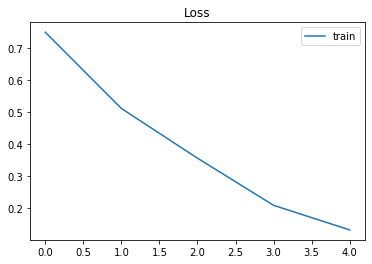

In [129]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show();

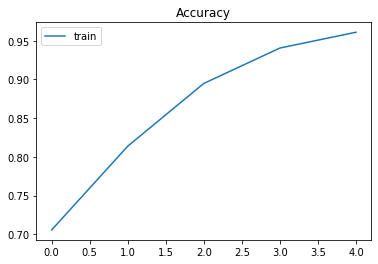

In [130]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
# plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

# Hyperparameter tuning

In [138]:
# from sklearn.model_selection import GridSearchCV

# weight_constraint = [1, 2, 3, 4, 5]
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)

# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_test_pad, y_train_encoded)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


# Testing the final (tuned) model

In [261]:
# # Final evaluation of the initial model
# scores = model.evaluate(X_test_pad, y_test_encoded, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

# Random predictions

In [163]:
predict_sentence("ontwyk die uitvraer want hy is ook ‘n verklapper")

'Afrikaans'

In [164]:
predict_sentence("It is common to pre-select an optimization algorithm to train your network and tune its parameters")

'English'

In [165]:
predict_sentence("Goedemorgen. Ik hoop dat mijn model goed presteert")

'Afrikaans'

# Saving the vocabulary to file

In [329]:
import json
# save to file
with open('vocab.txt', 'w') as file:
    json.dump(vocab_to_int, file)

# check - read dictionary from file
with open('vocab.txt', 'r') as file:
    orig_vocab_to_int = json.load(file)

# Saving the model

In [84]:
import pickle as pk
from keras.models import model_from_json

In [131]:
# serialize model to JSON
model_json = model2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Loading the model

In [132]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
scores = loaded_model.evaluate(X_test_pad, y_test_encoded, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Loaded model from disk
Accuracy: 97.29%


In [113]:
# saving the original test dataframe as CSV - this will be used at a later stage
# to test whether the loaded model returns the correct result 
# (expect to see an accuracy of 98.13%)
lang_data_test = pd.DataFrame(data = [X_test, y_test]).T

lang_data_test.head()
# saving lang_data_test to CSV
lang_data_test.to_csv('lang_data_test.csv', index = False)
